<h1>Build feature and output arrays

In [11]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

# lists for all data
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# load JSON-file
with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# collect data
for wpp in WPP_production_wind:
    all_turbine_types.append(wpp["Turbine"])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(wpp["Commission_date"] if wpp["Commission_date"] != "nan" else "2015/06")
    all_production_data.append(wpp["Production"])

# One-Hot-Encoding for turbine types
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# correct data format for commissioning dates
all_commissioning_dates = [
    "2015/06" if date == "nan" else f"{date}/06" if isinstance(date, str) and "/" not in date else date
    for date in all_commissioning_dates
]

# convert to datetime
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# calculate age
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# create combined features and output lists
combined_features_raw = []
output_raw = []

# convert data in feature arrays
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # repetitions for common features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # extract production values and wind speeds
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # combine all features
    combined_chunk = np.hstack((
        turbine_type_repeated,
        hub_height_repeated,
        capacity_repeated,
        age_repeated,
        wind_speeds
    ))

    # add the data
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

np.save("turbine_types_order.npy", encoder.categories_[0])

# combine all data chunks to one array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)

# round all values to two decimal places
combined_features_raw = np.round(combined_features_raw, decimals=2)
output_raw = np.round(output_raw, decimals=2)

In [12]:
import numpy as np

# Erstelle eine Maske mit 10.000 zufälligen Indizes
random_indices = np.random.choice(combined_features_raw.shape[0], 10000, replace=False)

combined_features_subset = combined_features_raw.copy()
output_subset = output_raw.copy()

# Extrahiere die entsprechenden Werte aus den Arrays
combined_features_subset = combined_features_subset[random_indices]
output_subset = output_subset[random_indices]

<h1>Scale feature vector and define Dataset

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import joblib

combined_features = combined_features_subset.copy()
output = output_subset.copy()

# Standardisierung der numerischen Features (individuell!)

# Separate Scaler für jedes Feature
scaler_wind = StandardScaler()
scaler_ages = StandardScaler()
scaler_capacities = StandardScaler()
scaler_hub_heights = StandardScaler()

# Skalieren der einzelnen Features
combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
combined_features[:, -3] = scaler_capacities.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale capacities
combined_features[:, -4] = scaler_hub_heights.fit_transform(combined_features[:, -4].reshape(-1, 1)).flatten()  # scale hub heights

# Speichere alle Scaler in einem Dictionary
scalers = {
    "winds": scaler_wind,
    "ages": scaler_ages,
    "capacities": scaler_capacities,
    "hub_heights": scaler_hub_heights,
}

# Speichere das Dictionary mit Joblib
joblib.dump(scalers, "scalers.pkl")

# Trainings- und Testaufteilung
train_features, test_features, train_targets, test_targets = train_test_split(combined_features, output, test_size=0.2, shuffle=True)

# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Erstellung der PyTorch-Datasets
train_val_dataset = WindPowerDataset(train_features, train_targets)
test_dataset = WindPowerDataset(test_features, test_targets)

# Ausgabe der Formen
print("Train and Validation Features Shape:", train_features.shape)
print("Train and Validation Targets Shape:", train_targets.shape)
print("Test Features Shape:", test_features.shape)
print("Test Targets Shape:", test_targets.shape)

Train and Validation Features Shape: (8000, 50)
Train and Validation Targets Shape: (8000, 1)
Test Features Shape: (2000, 50)
Test Targets Shape: (2000, 1)


<h1>Define Model

In [15]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # define layers as nn.Sequential, for better visualisability in TensorBoard and compatibility with DeepExplainer from SHAP
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# class MLP(nn.Module):
#     def __init__(self, input_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 32)
#         self.fc5 = nn.Linear(32, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.relu(self.fc4(x))
#         x = self.fc5(x)  # No activation in the output layer for regression
#         return x

In [14]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, use_dropout=False, dropout_rate=0.3, 
                 use_batch_norm=False, activation_fn=nn.ReLU):
        super(MLP, self).__init__()

        layers = []

        # Erste Schicht
        layers.append(nn.Linear(input_size, 256))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(256))
        layers.append(activation_fn())

        # Zweite Schicht
        layers.append(nn.Linear(256, 128))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(128))
        layers.append(activation_fn())

        # Dritte Schicht
        layers.append(nn.Linear(128, 64))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(64))
        layers.append(activation_fn())

        # Vierte Schicht
        layers.append(nn.Linear(64, 32))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(32))
        layers.append(activation_fn())

        # Dropout nach der letzten versteckten Schicht (optional)
        if use_dropout:
            layers.append(nn.Dropout(dropout_rate))

        # Ausgabeschicht
        layers.append(nn.Linear(32, 1))

        # Modell zusammenstellen
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

<h1>1. Hyperparameter search: Training, Validation

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import optuna
import time
import pynvml
import psutil

# Ressourcenüberwachung initialisieren
gpu_used = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    pynvml.nvmlInit()
    gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # GPU 0 verwenden

n_splits = 4  # Anzahl der Folds für Kreuzvalidierung

def system_info():
    print("PyTorch Version:", torch.__version__)
    print("CUDA Available:", torch.cuda.is_available())
    print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    if torch.cuda.is_available():
        print("\nCUDA Details:")
        print("CUDA Version:", torch.version.cuda)
        print("Number of GPUs:", torch.cuda.device_count())
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
            print(f"  - Compute Capability: {torch.cuda.get_device_capability(i)}")
            print(f"  - Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
            print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")

if __name__ == "__main__":
    system_info()

# Bewertungsfunktion
def objective(trial):
    original_batch_size = trial.suggest_int("batch_size", 16, 128)
    batch_size = int(2 ** round(np.log2(original_batch_size)))  # Transformierte Batch-Größe
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    number_epochs = trial.suggest_int("number_epochs", 10, 100)
    use_dropout = trial.suggest_categorical("use_dropout", [True, False])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])

    # Speichern der transformierten Batch-Größe als Attribut
    trial.set_user_attr("transformed_batch_size", batch_size)

    print(f"Evaluating: batch_size={batch_size}, lr={lr:.5f}, number_epochs={number_epochs}, "
          f"use_dropout={use_dropout}, dropout_rate={dropout_rate}, use_batch_norm={use_batch_norm}")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    len_train_val_dataset = len(train_val_dataset)

    input_size = train_features.shape[1]
    avg_val_loss = 0.0  # Durchschnittlicher Validierungsverlust
    start_time = time.time()  # Zeitmessung starten
    max_memory_usage = 0  # Maximale Speicher-Auslastung

    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len_train_val_dataset)), 1):
        print(f"  Fold {fold}/{kf.n_splits}")

        model = torch.jit.script(MLP(input_size=input_size, use_dropout=use_dropout, dropout_rate=dropout_rate, use_batch_norm=use_batch_norm)).to(device)

        train_fold_dataset = Subset(train_val_dataset, train_idx)
        val_fold_dataset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)

        criterion = nn.HuberLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(number_epochs):
            model.train()
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if device == torch.device("cuda"):
                    memory_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
                    max_memory_usage = max(max_memory_usage, memory_info.used / 1024 ** 2)  # MB
                    global gpu_used
                    gpu_used = True
                else:
                    max_memory_usage = max(max_memory_usage, psutil.virtual_memory().used / 1024 ** 2)  # MB

        model.eval() # deactivates Batch normalisation and Dropout
        fold_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                val_outputs = model(batch_x)
                fold_val_loss += criterion(val_outputs, batch_y).item()
                
        avg_val_loss += fold_val_loss / len(val_loader)

    avg_val_loss /= kf.n_splits
    elapsed_time = time.time() - start_time

    weighted_score = 0.7 * avg_val_loss + 0.15 * elapsed_time + 0.15 * max_memory_usage

    trial.set_user_attr("resource_usage", max_memory_usage)
    trial.set_user_attr("elapsed_time", elapsed_time)
    trial.set_user_attr("avg_val_loss", avg_val_loss)
    trial.set_user_attr("weighted_score", weighted_score)

    return weighted_score

# Optuna-Optimierung starten
best_val_loss = float("inf")
best_params = None

study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\nBeste Parameterkombination:")
print(study.best_params)

# Ausgabe des besten Validierungsverlusts
best_trial = study.best_trial
print(f"Bester Validierungsverlust: {best_trial.user_attrs['avg_val_loss']}")

for trial in study.trials:
    print(trial)

# Debugging: Überprüfung, ob GPU verwendet wurde
if gpu_used:
    print("GPU wurde erfolgreich während des Trainings verwendet.")
else:
    print("GPU wurde nicht verwendet.")

[I 2024-12-29 10:34:14,941] A new study created in memory with name: no-name-525f1fc7-1deb-4bbb-9e18-351479e0a262


PyTorch Version: 2.5.1
CUDA Available: False
Device: cpu


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: batch_size=64, lr=0.00242, number_epochs=1, use_dropout=True, dropout_rate=0.32322596965577166, use_batch_norm=True
  Fold 1/4
    Epoch 1/1
15.04929367860272
  Fold 2/4
    Epoch 1/1
[W 2024-12-29 10:35:54,564] Trial 0 failed with parameters: {'batch_size': 56, 'lr': 0.0024180495694975583, 'number_epochs': 1, 'use_dropout': True, 'dropout_rate': 0.32322596965577166, 'use_batch_norm': True} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\alexa\AppData\Local\Temp\ipykernel_26132\1513485689.py", line 79, in objective
    for batch_x, batch_y in train_loader:
                            ^^^^^^^^^^^^
  File "c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\torch\utils\data\dataloader.py", line 697, in __next__
    wi

KeyboardInterrupt: 

<h1>2. With best hyperparameters: Training and Testing

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from torch.nn import HuberLoss, MSELoss, L1Loss

log_dir = "runs"

# TensorBoard-Prozess beenden
try:
    if platform.system() == "Windows":
        subprocess.run(["taskkill", "/IM", "tensorboard.exe", "/F"], check=True)
    else:
        subprocess.run(["pkill", "-f", "tensorboard"], check=True)
    print("Terminated TensorBoard process")
except subprocess.CalledProcessError:
    print("No TensorBoard process found or could not be terminated")

# Log-Verzeichnis löschen
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
os.makedirs(log_dir, exist_ok=True)

subprocess.Popen(["tensorboard", "--logdir=runs", "--bind_all"])
print("TensorBoard started.")

# TensorBoard-Writer starten
writer = SummaryWriter(f"{log_dir}/final_training")

# Daten splitten
train_x, test_x, train_y, test_y = train_test_split(train_features, train_targets, test_size=0.2, shuffle=True, random_state=42)

# Modell initialisieren
model = MLP(
    input_size=train_x.shape[1],
    use_dropout=best_params["use_dropout"],
    dropout_rate=best_params["dropout_rate"],
    use_batch_norm=best_params["use_batch_norm"]
).to(device)

# Visualisierung des Modells
example_input = torch.randn(best_params["batch_size"], train_x.shape[1]).to(device)
writer.add_graph(model, example_input)

# Trainings-Konfiguration
criterion = HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

# Daten-Loader
train_loader = DataLoader(list(zip(train_x, train_y)), batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(list(zip(test_x, test_y)), batch_size=best_params["batch_size"], shuffle=False)

# Training
num_epochs = best_params["number_epochs"]

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    writer.add_scalar("Training Loss", train_loss, epoch)

# Testen
model.eval()
mae_criterion = L1Loss()
mse_criterion = MSELoss()
huber_criterion = HuberLoss()

test_loss_mae, test_loss_mse, test_loss_huber = 0, 0, 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        preds = model(batch_x)
        
        test_loss_mae += mae_criterion(preds, batch_y).item()
        test_loss_mse += mse_criterion(preds, batch_y).item()
        test_loss_huber += huber_criterion(preds, batch_y).item()

test_loss_mae /= len(test_loader)
test_loss_mse /= len(test_loader)
test_loss_huber /= len(test_loader)

# Ergebnisse anzeigen
print(f"Endgültiger MAE: {test_loss_mae:.4f}")
print(f"Endgültiger MSE: {test_loss_mse:.4f}")
print(f"Endgültiger Huber Loss: {test_loss_huber:.4f}")

# TensorBoard-Writer schließen
writer.close()

<h1>3. With all data: Training for deployment

In [ ]:
# Modell initialisieren
model = MLP(
    input_size=train_features.shape[1],
    use_dropout=best_params["use_dropout"],
    dropout_rate=best_params["dropout_rate"],
    use_batch_norm=best_params["use_batch_norm"]
).to(device)

# Trainings-Konfiguration
criterion = HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

# Daten-Loader für alle Trainingsdaten
train_loader = DataLoader(list(zip(train_features, train_targets)), batch_size=best_params["batch_size"], shuffle=True)

# Training
num_epochs = best_params["number_epochs"]

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    writer.add_scalar("Final Training Loss", train_loss, epoch)

# Modell speichern
torch.save(model.state_dict(), "trained_model_for_deployment.pth")
print("Modell für Deployment gespeichert!")

old code for hyperparameter search

In [25]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import shutil
import os
import subprocess
from torch.utils.tensorboard import SummaryWriter
import platform

# Hyperparameter-Raum definieren
# param_space = {
#     "hidden_size": [32, 64, 128, 256],
#     "batch_size": [16, 32, 64],
#     "lr": [1e-2, 1e-3, 1e-4],
#     "number_epochs": [20, 50, 100],
# }
param_space = {
    "hidden_size": [32],
    "batch_size": [32],
    "lr": [1e-3],
    "number_epochs": [20],
    "n_splits": [2]
}

# Funktion zur Auswahl eines zufälligen Parametersets
def random_search(param_space, n_trials):
    trials = []
    for _ in range(n_trials):
        trial = {key: random.choice(values) for key, values in param_space.items()}
        trials.append(trial)
    return trials

# Generiere zufällige Parameterkombinationen
n_trials = 1
params = random_search(param_space, n_trials)[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# KFold-Objekt
kf = KFold(n_splits=params["n_splits"], shuffle=True, random_state=42)
len_train_val_dataset = len(train_val_dataset)

# Ergebnis-Tracking
best_val_loss = float("inf")
best_params = None
results = []

input_size = train_features.shape[1]

# TensorBoard-Prozess beenden
try:
    if platform.system() == "Windows":
        subprocess.run(["taskkill", "/IM", "tensorboard.exe", "/F"], check=True)
    else:
        subprocess.run(["pkill", "-f", "tensorboard"], check=True)
    print("Terminated TensorBoard process")
except subprocess.CalledProcessError:
    print("No TensorBoard process found or could not be terminated")

log_dir = "runs"

# Löschen, wenn der Ordner existiert
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# TensorBoard neu starten
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

subprocess.Popen(["tensorboard", "--logdir=runs", "--bind_all"])
print("TensorBoard started.")

avg_val_loss = 0.0  # average validation loss over all folds

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len_train_val_dataset)), 1):

    print(f"  Fold {fold}/{kf.n_splits}")
    writer = SummaryWriter(f"{log_dir}/fold_{fold}")

    # model
    example_input = torch.randn(params["batch_size"], input_size).to(device)
    model = MLP(input_size=input_size).to(device)

    # visualisation of model architecture
    writer.add_graph(model, example_input)
    
    train_fold_dataset = Subset(train_val_dataset, train_idx)
    val_fold_dataset = Subset(train_val_dataset, val_idx)

    train_loader = DataLoader(train_fold_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_fold_dataset, batch_size=params["batch_size"], shuffle=True)

    # loss and optimiser
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # training
    for epoch in range(params["number_epochs"]):
        print(f"    Epoch {epoch+1}/{params['number_epochs']}")
        model.train()
        training_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            training_loss += loss.item()

            optimizer.zero_grad()  # Gradienten zurücksetzen
            loss.backward()        # Gradienten berechnen
            optimizer.step()       # Parameter aktualisieren

        # protocol training loss
        writer.add_scalar("Training Loss", training_loss / len(train_loader), epoch)

        print(f"    Fold Training Loss: {training_loss / len(train_loader):.4f}")

    # validation
    model.eval()
    fold_val_loss = 0.0
    MAE_loss = 0.0
    MSE_loss = 0.0

    # for later visualisation
    batch_x_all = []
    batch_y_all = []
    val_outputs_all = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:

            batch_x_all.append(batch_x.detach().cpu().numpy())
            batch_y_all.append(batch_y.detach().cpu().numpy())
            
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            val_outputs = model(batch_x)

            val_outputs_all.append(val_outputs.detach().cpu().numpy())

            fold_val_loss += criterion(val_outputs, batch_y).item()
    
    batch_x_all = np.concatenate(batch_x_all)
    batch_y_all = np.concatenate(batch_y_all)
    val_outputs_all = np.concatenate(val_outputs_all)

    fold_val_loss /= len(val_loader)
    MAE_loss /= len(val_loader)
    MSE_loss /= len(val_loader)
    writer.add_scalar("Validation Loss", fold_val_loss, epoch)
    print(f"    Fold Validation Loss: {fold_val_loss:.4f}")
    
    avg_val_loss += fold_val_loss

    # TensorBoard schließen
    writer.close()

avg_val_loss /= kf.n_splits
print(f"  Trial Average Validation Loss: {avg_val_loss:.4f}")

# Ergebnisse speichern
results.append({"params": params, "avg_val_loss": avg_val_loss})

# Bestes Ergebnis aktualisieren
if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    best_params = params

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Speichere das Modellgewicht separat
weights_path = "trained_model_weights.pth"
torch.save(model.state_dict(), weights_path)
print(f"Modellgewichte gespeichert in {weights_path}")

# Speichere die Metadaten separat
metadata_path = "model_metadata.pth"
metadata = {
    "input_size": input_size,
}
torch.save(metadata, metadata_path)
print(f"Metadaten gespeichert in {metadata_path}")

Terminated TensorBoard process
TensorBoard started.
  Fold 1/2
    Epoch 1/20
    Fold Training Loss: 46.5904
    Epoch 2/20
    Fold Training Loss: 29.0141
    Epoch 3/20
    Fold Training Loss: 24.9694
    Epoch 4/20
    Fold Training Loss: 22.3554
    Epoch 5/20
    Fold Training Loss: 21.3174
    Epoch 6/20
    Fold Training Loss: 20.8184
    Epoch 7/20
    Fold Training Loss: 20.4747
    Epoch 8/20
    Fold Training Loss: 20.2143
    Epoch 9/20
    Fold Training Loss: 20.2265
    Epoch 10/20
    Fold Training Loss: 20.0789
    Epoch 11/20
    Fold Training Loss: 19.6944
    Epoch 12/20
    Fold Training Loss: 19.5163
    Epoch 13/20
    Fold Training Loss: 19.4861
    Epoch 14/20
    Fold Training Loss: 19.6316
    Epoch 15/20
    Fold Training Loss: 19.5305
    Epoch 16/20
    Fold Training Loss: 19.4237
    Epoch 17/20
    Fold Training Loss: 19.4957
    Epoch 18/20
    Fold Training Loss: 19.1780
    Epoch 19/20
    Fold Training Loss: 19.0804
    Epoch 20/20
    Fold Training 

<h1>Visualisation of validation results

In [19]:
import matplotlib.pyplot as plt

# Modell auf Evaluation setzen
model.eval()

# Vorhersagen für alle Daten generieren
predictions, true_values = [], []

with torch.no_grad():
    for batch_x, batch_y in DataLoader(list(zip(train_features, train_targets)), batch_size=best_params["batch_size"], shuffle=False):
        batch_x = batch_x.to(device)
        preds = model(batch_x).cpu().numpy()
        predictions.extend(preds)
        true_values.extend(batch_y.cpu().numpy())

# Visualisierung
plt.figure(figsize=(12, 6))
plt.plot(true_values, label="Tatsächliche Werte", marker='o')
plt.plot(predictions, label="Vorhergesagte Werte", marker='x')
plt.title("Tatsächliche vs. Vorhergesagte Werte")
plt.xlabel("Datenpunkt-Index")
plt.ylabel("Wert")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

TypeError: 'NoneType' object is not subscriptable

C:\Users\alexa\AppData\Local\Temp\ipykernel_9708\3334778685.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', 2*len(unique_turbine_types))


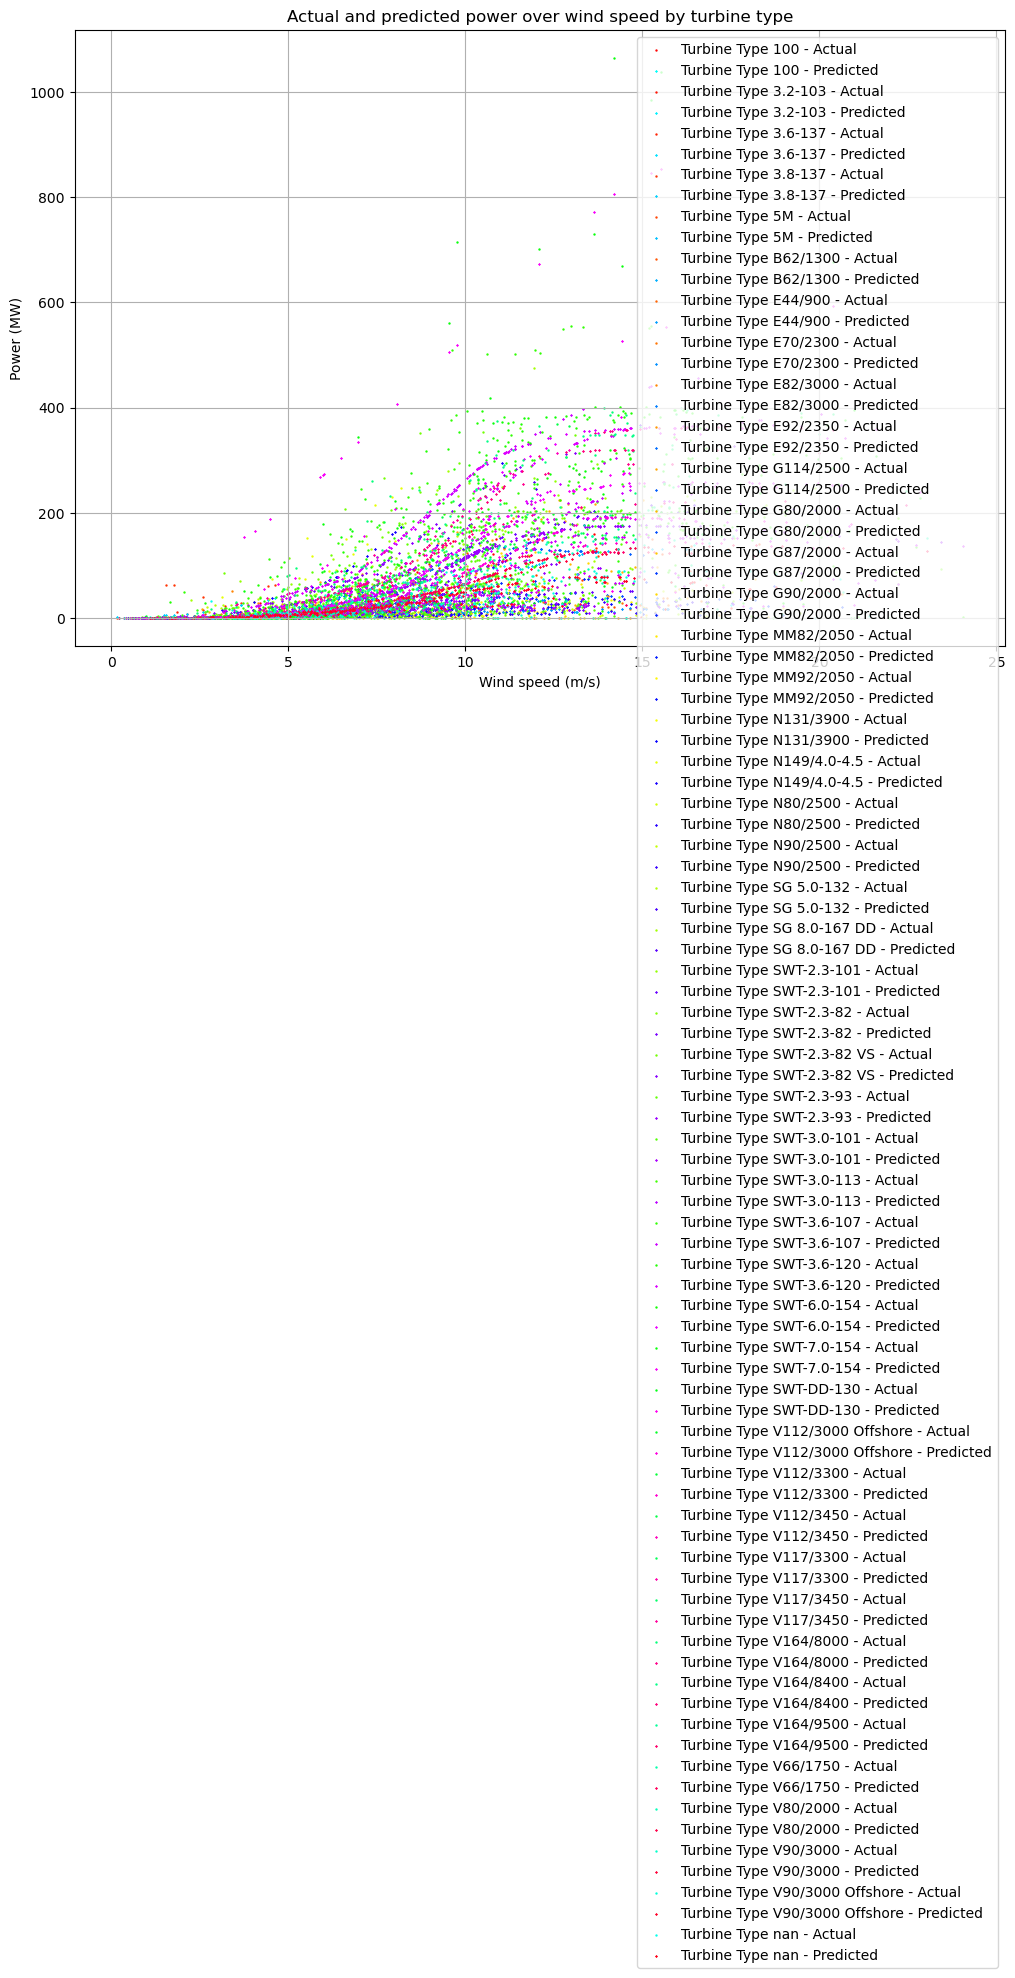

In [20]:
import matplotlib.pyplot as plt

# reconstruct original wind speeds
wind_speeds_validation = scaler_wind.inverse_transform(batch_x_all[:, -1].reshape(-1, 1)).flatten()

# reconstruct original turbine types
turbine_types_validation = np.argmax(batch_x_all[:, 0:-4], axis=1)
turbine_types_validation = encoder.categories_[0][turbine_types_validation]

# Erstellen eines Farbschemas für verschiedene Turbinentypen
unique_turbine_types = np.unique(turbine_types_validation)
colors = plt.cm.get_cmap('hsv', 2*len(unique_turbine_types))

# Erstellen des Scatterplots mit verschiedenen Farben für Turbinentypen
plt.figure(figsize=(12, 8))

# Für jeden Turbinentyp einen Scatter-Plot mit einer anderen Farbe
for i, turbine_type in enumerate(unique_turbine_types):
    mask = turbine_types_validation == turbine_type  # Maske für den jeweiligen Turbinentyp
    plt.scatter(wind_speeds_validation[mask], batch_y_all[mask], s=0.5, color=colors(i), label=f"Turbine Type {turbine_type} - Actual")
    plt.scatter(wind_speeds_validation[mask], val_outputs_all[mask], s=0.5, color=colors(len(unique_turbine_types)+i), marker='x', label=f"Turbine Type {turbine_type} - Predicted")

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed by turbine type')
plt.legend()
plt.grid(True)
plt.show()

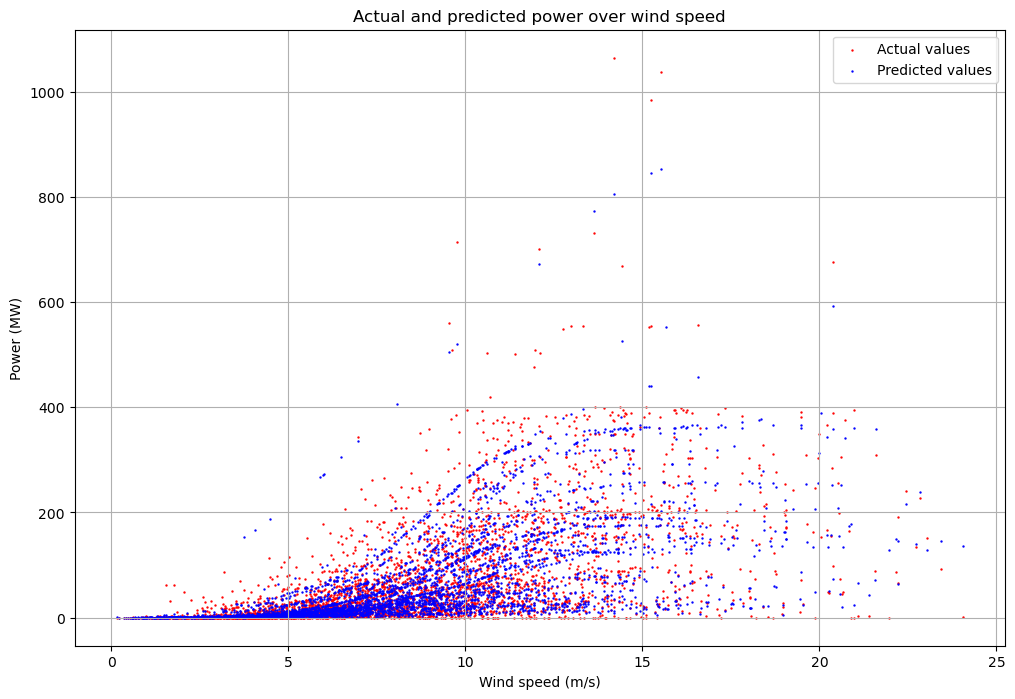

C:\Users\alexa\AppData\Local\Temp\ipykernel_9708\1354011826.py:21: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(wind_speeds_validation, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.5)


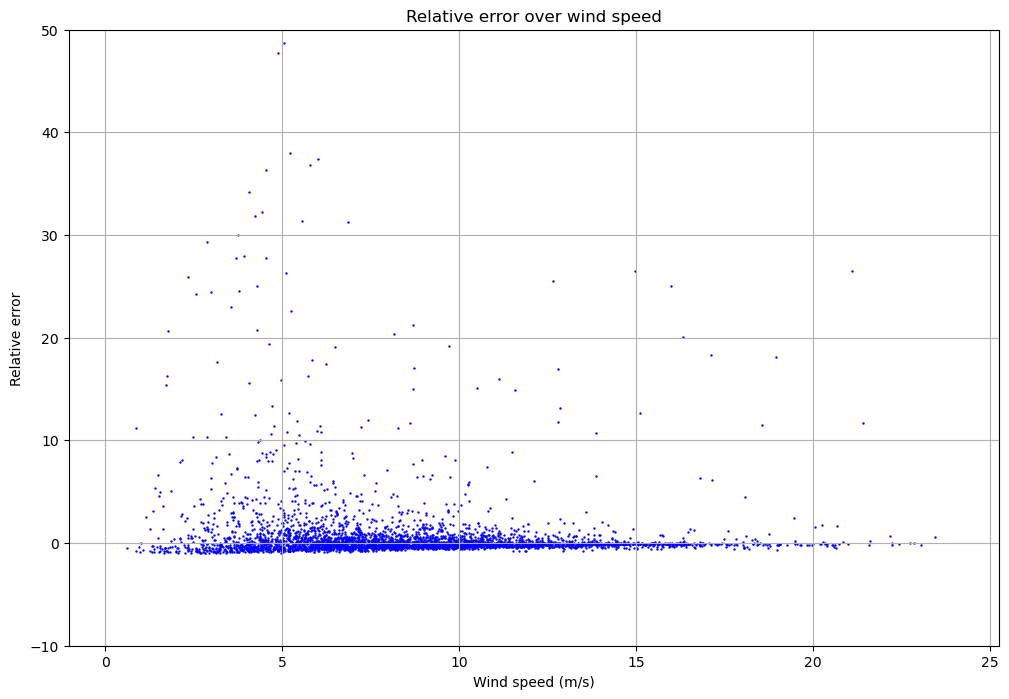

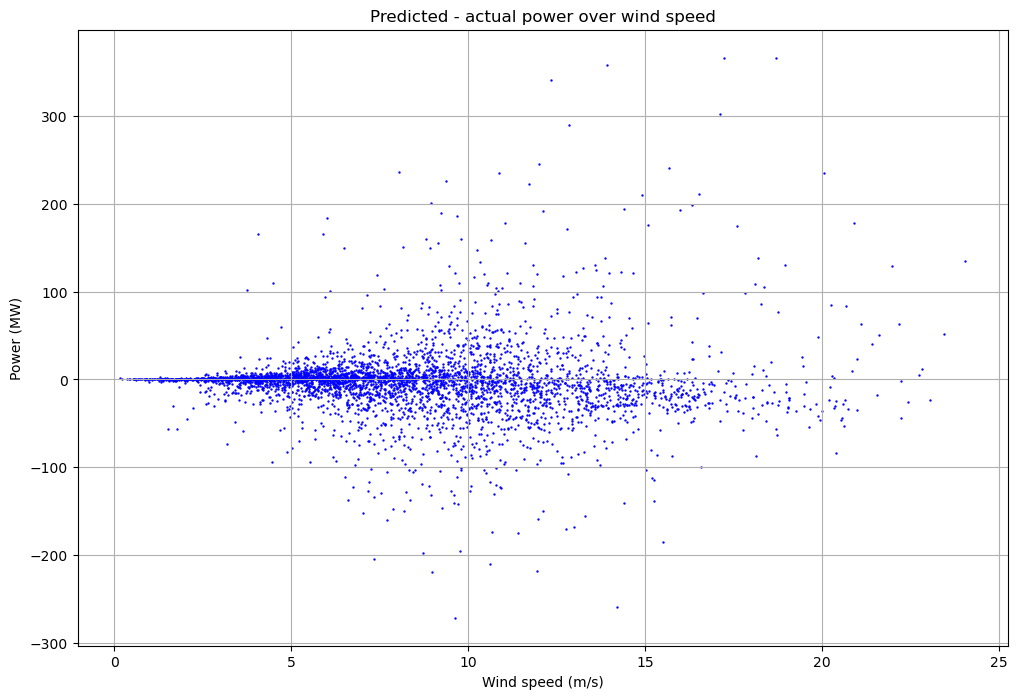

last ten validation values:
       wind speed  actual values  predicted values
0           7.83       7.210000         13.884449
1           3.42       1.020000          0.680776
2           6.44       4.050000          4.817784
3           8.22      52.299999         42.206387
4          11.68     138.369995        103.977608
...          ...            ...               ...
3995       10.74       7.680000         17.882013
3996        4.79       6.300000          5.806384
3997        8.85     106.870003         61.875587
3998       15.03     381.450012        361.804596
3999       14.01      32.009998         26.239983

[4000 rows x 3 columns]


In [21]:
import matplotlib.pyplot as plt

# reconstruct original wind speeds
wind_speeds_validation = wind_scaler.inverse_transform(batch_x_all[:, -1].reshape(-1, 1)).flatten()

# reconstruct original turbine types
turbine_types_validation = np.argmax(batch_x_all[:, 0:-4], axis=1)
turbine_types_validation = encoder.categories_[0][turbine_types_validation]

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_validation, batch_y_all, s=0.5, color='red', label="Actual values")
plt.scatter(wind_speeds_validation, val_outputs_all, s=0.5, color='blue', label="Predicted values")
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_validation, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.5)
plt.ylim(-10, 50)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Relative error')
plt.title('Relative error over wind speed')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_validation, val_outputs_all-batch_y_all, color='blue', s=0.5)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Predicted - actual power over wind speed')
plt.grid(True)
plt.show()

# Tabelle erstellen und anzeigen
results_df = pd.DataFrame({
    "wind speed": wind_speeds_validation,
    "actual values": batch_y_all.flatten(),
    "predicted values": val_outputs_all.flatten()
})
print("validation values:\n", results_df)

Histograms showing error distribution

In [ ]:
import numpy as np

# Fehlerberechnung
absolute_errors = val_outputs_all - batch_y_all
relative_errors = (val_outputs_all - batch_y_all) / (batch_y_all + 1e-8)

# Berechnung von Mittelwert und Standardabweichung
mean_abs_error = np.mean(absolute_errors)
std_abs_error = np.std(absolute_errors)

mean_rel_error = np.mean(relative_errors)
std_rel_error = np.std(relative_errors)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Absoluter Fehler: Histogramm um 0 zentrieren
plt.figure(figsize=(12, 8))
sns.histplot(absolute_errors, bins=200, kde=True, color='skyblue')
plt.xlim(mean_abs_error - 3*std_abs_error, mean_abs_error + 3*std_abs_error)
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Zentriertes Histogramm der absoluten Fehler")
plt.xlabel("Absoluter Fehler (MW)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

# Relativer Fehler: Histogramm um 0 zentrieren
plt.figure(figsize=(12, 8))
sns.histplot(relative_errors, bins=2000, kde=True, color='orange')
plt.xlim(mean_rel_error - std_rel_error, mean_rel_error + std_rel_error)
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Zentriertes Histogramm der relativen Fehler")
plt.xlabel("Relativer Fehler (Bruchteil)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


<h1>Evaluate Feature Importance

In [86]:
import numpy as np

# Feature-Namen definieren
feature_names = np.array((
    list(encoder.get_feature_names_out(["Turbine"])) + 
    ["Hub_height", "Capacity", "Age", "Wind_speed"]
))

In [124]:
import numpy as np

# Maske mit zufälligen Indizes erstellen
random_indices = np.random.choice(len(combined_features), size=1000, replace=False)

# Werte aus combined_features basierend auf der Maske auswählen
masked_features = combined_features[random_indices]

model.eval()

1. shapley-values

In [105]:
import torch
import shap

# Eingabe für den SHAP-Explainer vorbereiten
input_tensor = torch.tensor(masked_features, dtype=torch.float32).to(device)

# SHAP-Explainer erstellen
explainer = shap.GradientExplainer(model, input_tensor)

# SHAP-Werte berechnen
shap_values = explainer.shap_values(input_tensor)

# SHAP-Werte umformen
shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

In [ ]:
import shap

shap.summary_plot(shap_values_reshaped, masked_features, feature_names)

In [ ]:
import shap
import torch

shap.initjs()

# Modellvorhersagen auf dem Eingabedatensatz berechnen
base_value = model(torch.tensor(masked_features, dtype=torch.float32).to(device)).mean().item()

shap.plots.force(base_value, shap_values_reshaped, feature_names)

In [ ]:
import shap
import numpy as np

# Base Value in ein Array umwandeln
base_values_array = np.full((shap_values_reshaped.shape[0],), base_value)

# SHAP Explanation-Objekt erstellen
shap_values_explanation = shap.Explanation(
    values=shap_values_reshaped,
    base_values=base_values_array,  # Array statt float
    data=masked_features,  # Eingabedaten
    feature_names=feature_names  # Feature-Namen
)

# Bar-Plot erstellen
shap.plots.bar(shap_values_explanation)

2. gradient method

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Modell in Evaluierungsmodus
model.eval()

# Eingabegröße reduzieren
input_tensor = torch.tensor(masked_features, dtype=torch.float32, requires_grad=True).to(device)

# Vorhersage berechnen
outputs = model(input_tensor)

# Mittleren Output für den Gradienten berechnen
outputs.mean().backward()

# Gradienten extrahieren und sortieren
feature_importance = input_tensor.grad.abs().mean(dim=0).cpu().detach().numpy()

# Nach Wichtigkeit sortieren
sorted_idx = np.argsort(feature_importance)

# Visualisierung
plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Average Gradient Magnitude")
plt.title("Feature Importance using Gradients")
plt.show()

3. Spearman Correlation Coefficient Matrix

In [ ]:
import pandas as pd
import seaborn as sns

num_turbine_type_columns = turbine_types_onehot.shape[1]

# DataFrame ohne Turbinentypen erstellen
df = pd.DataFrame(
    combined_features[:, num_turbine_type_columns:], 
    columns=["Hub Height", "Capacity", "Commissioning Date", "Wind Speed"]
)

# Ausgabe hinzufügen
df['Power'] = output.flatten()

# Spearman-Korrelation berechnen
spearman_corr_matrix = df.corr(method='spearman')

# Farbcodierte Tabelle anzeigen
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Spearman Correlation Heatmap")
plt.show()